In [130]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from scipy import stats
import networkx as nx
from tqdm import tqdm_notebook
%matplotlib inline

In [4]:
# Load MFCC features
mfcc_dict = {}

for filename in os.listdir('data/features/mfcc/'):
    id = int(filename.split('.')[0])
    mfcc_dict[id] = np.load('data/features/mfcc/' + filename)

In [132]:
# Load artist data
artists = pd.read_csv('data/allmusic/artists_cleaned.csv')

In [133]:
# Compute genre popularity
artists['main_genre'].value_counts()

Pop/Rock          7185
Jazz              1462
R&B;              1100
Unknown           1090
Rap                967
Electronic         965
Country            751
Latin              429
Blues              410
International      337
Vocal              313
Folk               305
Religious          274
Reggae             264
Classical          257
Comedy/Spoken      181
Avant-Garde        128
New Age            113
Stage & Screen     111
Easy Listening      47
Children's          14
Holiday              1
Name: main_genre, dtype: int64

In [7]:
# Top 7 most popular genres, removing 'Unknown'
top_genres = artists['main_genre'].value_counts()[:8].index.tolist()
top_genres.remove('Unknown')

In [8]:
# Filter for ids of artists with > 25 followers
ids_filtered = artists[(artists['main_genre'].isin(top_genres))]['id'].tolist()

In [9]:
# Create feature matrix
X = []
ids = []
# Create lists of artist name and main genre for visualization purposes
artist_names = []
main_genres = []

for id in ids_filtered:
    try:
        X.append(mfcc_dict[id].flatten())
        ids.append(id)
        main_genres.append(artists[artists['id'] == id]['main_genre'].tolist()[0])
        artist_names.append(artists[artists['id'] == id]['name'].tolist()[0])

    # we don't have audio for some ids, so pass
    except Exception as e:
        pass

X = np.array(X)

# PCA

In [10]:
pca = PCA(n_components=3)
pca.fit(X)
# Reduce dimensionality of X
X_reduced = pca.transform(X)

In [11]:
# Percentage of variance explained
pca.explained_variance_ratio_

array([ 0.472716  ,  0.07717337,  0.03171754])

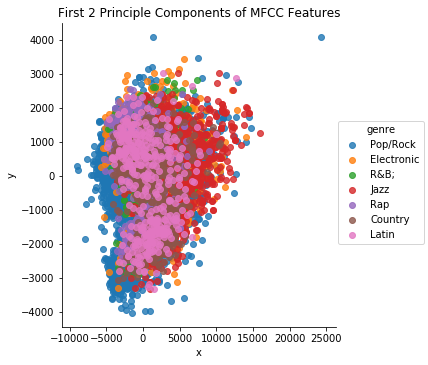

In [12]:
pca_df = pd.DataFrame(dict(x=X_reduced[:,0], y=X_reduced[:,1], genre=main_genres, name=artist_names))
sns.lmplot('x', 'y', data=pca_df, hue='genre', fit_reg=False)
plt.title('First 2 Principle Components of MFCC Features')

# KMeans on PCA Components

In [48]:
kmeans = KMeans(n_clusters=7)
cluster_assignments = kmeans.fit_predict(X_reduced)

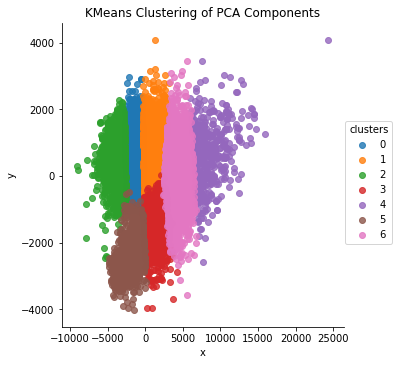

In [49]:
kmeans_df = pd.DataFrame(dict(x=X_reduced[:,0], y=X_reduced[:,1], clusters=cluster_assignments, name=artist_names))
sns.lmplot('x', 'y', data=kmeans_df, hue='clusters', fit_reg=False)
plt.title('KMeans Clustering of PCA Components')

In [99]:
# # For each cluster, compute the majority genre per cluster
# for i in range(7):
#     # Get indices of artists belonging to that cluster
#     member_indices = np.argwhere(cluster_assignments == i).flatten()
#     # Get list of genres corresponding to those indices
#     genres_per_cluster = [main_genres[index] for index in member_indices]
#     print "Cluster {}:".format(i)
#     print pd.Series(genres_per_cluster).value_counts()
#     print 

# Plot Most Popular Influencer Per Genre and Immediate Followers

In [87]:
# Get series of indices of most popular artist by genre
influencers_by_genre = artists.groupby('main_genre')['outdegree'].idxmax()

In [104]:
# Load allmusic influence graph
influence_graph = nx.read_multiline_adjlist('networks/allmusic_influence_graph.txt', nodetype=int)

In [147]:
# List the influencer for each artist if the influencer is among the top influencers, otherwise None
influencers = []

# Iterate through ids
for id in tqdm_notebook(ids):
    current_artist_genre = artists[artists['id'] == id]['main_genre'].tolist()[0]
    
    influencer_found = False
    
    for genre, top_influencer_idx in influencers_by_genre.iteritems():
        if genre in top_genres:
            top_influencer_id = artists.iloc[top_influencer_idx]['id']
            top_influencer_genre = artists.iloc[top_influencer_idx]['main_genre']

            if (influence_graph.has_edge(top_influencer_id, id) or top_influencer_id == id) and (not influencer_found) and (current_artist_genre == top_influencer_genre):
                influencers.append(artists.iloc[top_influencer_idx]['name'].decode('utf-8'))
                influencer_found = True
    
    if not influencer_found:
        influencers.append(None)

A Jupyter Widget

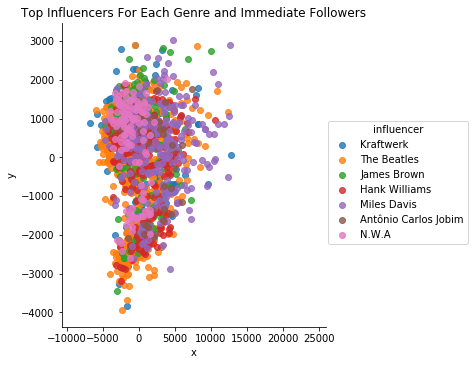

In [139]:
top_influencers_df = pd.DataFrame(dict(x=X_reduced[:,0], y=X_reduced[:,1], influencer=influencers, name=artist_names))
sns.lmplot('x', 'y', data=top_influencers_df, hue='influencer', fit_reg=False)
plt.title('Top Influencers For Each Genre and Immediate Followers')

# TSNE

In [330]:
tsne = TSNE()
X_embedded = tsne.fit_transform(X[:1000])

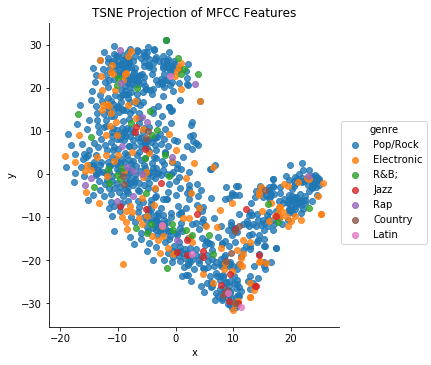

In [332]:
tsne_df = pd.DataFrame(dict(x=X_embedded[:,0], y=X_embedded[:,1], genre=main_genres[:1000], name=artist_names[:1000]))
sns.lmplot('x', 'y', data=tsne_df, hue='genre', fit_reg=False)
plt.title('TSNE Projection of MFCC Features')

It looks like TSNE projection doesn't seem to yield very good separation between genres.